# Extended Cox model (recurrent events, time varying features)

In this notebook I implemented the pipeline for the fitting of the realizations of the compensator of the counting process about the beta drugs purchases.

The data comes from patients affected by heart disease in a follow-up interval of one year from the exit-time of the first hospitalization. 

The following steps are made:

1. Model choice
2. Model fitting
3. Smoothing of baseline Hazard
4. Reconstruction of the patient-specific cumulative Hazards
5. Check of Martingale residuals

In [2]:
require(data.table)
require(ggplot2)
require(survival)
library(cobs)     # Package for constrained L1 B-splines
require(latex2exp)

options(repr.plot.width=6, repr.plot.height=4)

In [3]:
path = '/Users/davide/Documents/universita/tesi/src/fit_compensators/'
setwd(path)
source('compute_cumulative_hazards.R')
load('../../data/preprocessed_data_beta.RData')

sel_df = beta_df

In [4]:
# preprocessed data
head(sel_df, n = 8)

id,start,stop,status,sex,age_in,Nm,y
10000243,-0.5,5.0,1,M,69,0,0
10000243,5.0,49.0,1,M,69,1,20
10000243,49.0,365.5,0,M,69,2,60
10000471,-0.5,365.5,0,F,79,0,0
10000717,-0.5,72.0,1,M,72,0,0
10000717,72.0,176.0,1,M,72,1,14
10000717,176.0,197.0,1,M,72,2,28
10000717,197.0,323.0,1,M,72,3,35


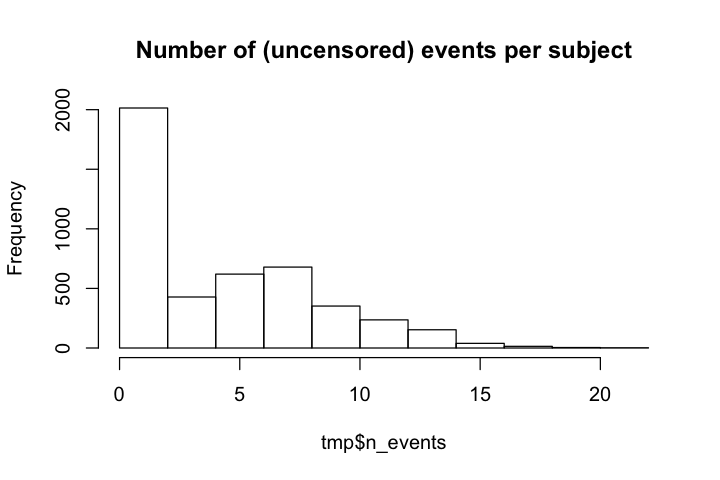

In [5]:
tmp = sel_df[,list('n_events' = max(Nm)),by = 'id']
hist(tmp$n_events, main = 'Number of (uncensored) events per subject')

# Model Choice

## Evaluate goodness of fit 

In [5]:
set.seed(123)
#Randomly shuffle the patients
patients = sample(unique(sel_df$id))
#Create 10 equally size folds
folds <- cut(seq(1,length(patients)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
scores = NULL
pb <- txtProgressBar(min = 0, max = 10, style = 3)
for(i in 1:10){
    setTxtProgressBar(pb, i)
    #Segement patients by fold 
    validIndexes <- which(folds==i,arr.ind=TRUE)
    valid_patients <- patients[validIndexes]
    train_patients <- patients[-validIndexes]
    # Split train, valid
    train = sel_df[id %in% train_patients]
    valid = sel_df[id %in% valid_patients]
    
    # fit
    models = list(
        coxph(Surv(start,stop,status)~ age_in + Nm + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + y + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + y + Nm:y + cluster(id), data = train),
        
        # log(Nm+1)
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + y + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + y + log(Nm+1):y + cluster(id), data = train),
        
        # log(y+1)
        coxph(Surv(start,stop,status)~ age_in + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(y+1) + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + log(y+1) + Nm:log(y+1) + cluster(id), data = train),
        
        # log(Nm+1), log(y+1)
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(y+1) + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + log(y+1) + log(Nm+1):log(y+1) + cluster(id), data = train)
    )
    # predict, evaluate
    fold_scores = c()
    for(model in models){
        # evaluate martingale residuals at validation events
        valid_model = coxph(model$formula,data = valid, init = model$coefficients, iter.max = 0)
        res = residuals(valid_model, type = "martingale")
        score = mean(abs(res)) # mean absolute residual 
        fold_scores = c(fold_scores,score)
    }
    scores = rbind(scores,fold_scores)
}
rownames(scores) = 1:10
colnames(scores) = names(models)

  |======================================================================| 100%

In [6]:
# summarize CV scores
mean_scores = colMeans(scores)
best_score = min(mean_scores)
worst_score = max(mean_scores)

In [7]:
# print cv scores
print('****************** Cross validation mean absolute Martingale residual ******************')
cat('\n')
print('|------------------------|--------------------------------------|')
print('|   MEAN ABS. RESIDUAL   |               FORMULA                |')
print('|------------------------|--------------------------------------|')
for(i in 1:length(models)){
    score = mean_scores[i]
    if(score != best_score & score != worst_score){
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3]))
    }else if (score == best_score){
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3], '                 <------ BEST MODEL'))
    }else{
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3], '                 <------ WORST MODEL'))
    }
}

[1] "****************** Cross validation mean absolute Martingale residual ******************"

[1] "|------------------------|--------------------------------------|"
[1] "|   MEAN ABS. RESIDUAL   |               FORMULA                |"
[1] "|------------------------|--------------------------------------|"
[1] "|        0.648           |  age_in + Nm + cluster(id)"
[1] "|        0.802           |  age_in + y + cluster(id)"
[1] "|        0.649           |  age_in + Nm + y + cluster(id)"
[1] "|        0.804           |  age_in + Nm:y + cluster(id)                  <------ WORST MODEL"
[1] "|        0.643           |  age_in + Nm + Nm:y + cluster(id)"
[1] "|        0.8           |  age_in + y + Nm:y + cluster(id)"
[1] "|        0.619           |  age_in + Nm + y + Nm:y + cluster(id)"
[1] "|        0.555           |  age_in + log(Nm + 1) + cluster(id)"
[1] "|        0.555           |  age_in + log(Nm + 1) + y + cluster(id)"
[1] "|        0.8           |  age_in + log(Nm + 1):y + cluste

# Fit model

In [6]:
# in order to use some function in the following cells, we build features corresponding to the transformed variables
sel_df[,'logp1_Nm':= log(Nm+1)]
sel_df[,'logp1_y':= log(y+1)]
sel_df[,'logp1_Nm_times_logp1_y':= log(Nm+1)*log(y+1)]

In [7]:
model = coxph(Surv(start,stop,status)~ age_in + logp1_Nm + logp1_y + logp1_Nm_times_logp1_y + cluster(id),data = sel_df)
model

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + logp1_Nm + 
    logp1_y + logp1_Nm_times_logp1_y + cluster(id), data = sel_df)

                             coef  exp(coef)   se(coef)  robust se      z
age_in                 -0.0072085  0.9928175  0.0006142  0.0005585 -12.91
logp1_Nm                1.7112720  5.5359986  0.0311569  0.0305014  56.10
logp1_y                 0.1257604  1.1340104  0.0092429  0.0089184  14.10
logp1_Nm_times_logp1_y -0.1884350  0.8282544  0.0072864  0.0075344 -25.01
                            p
age_in                 <2e-16
logp1_Nm               <2e-16
logp1_y                <2e-16
logp1_Nm_times_logp1_y <2e-16

Likelihood ratio test=11663  on 4 df, p=< 2.2e-16
n= 24124, number of events= 19583 

# Compute and smooth baseline Hazards

In [8]:
# get baseline
bh = basehaz(model, centered = FALSE)

t <- bh$time
Lambda0 <- bh$hazard

In [9]:
# Smooth version of Lambda0
Lambda0S <- cobs(t,Lambda0,constraint=c("increase"),pointwise=matrix(c(0,-0.5,0),nrow=1),nknots=20,lambda=0,toler.kn=0)

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


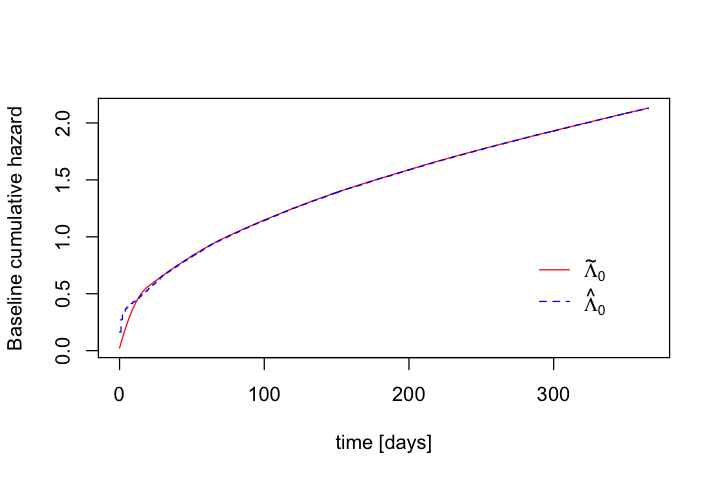

In [11]:
# Comparison between basic and smooth estimate
plot(Lambda0S$x,Lambda0S$fitted,type="l",main="",ylab="Baseline cumulative hazard",xlab="time [days]", col = 'red')
points(t,Lambda0,type="s",lty=2, col = 'blue')

legend(280, 0.9,legend=c(TeX("$\\tilde{\\Lambda}_0"), TeX("$\\hat{\\Lambda}_0")),col=c("red", "blue"), lty=1:2, cex=1,y.intersp=3,box.lty=0)

# Reconstruct patients cumulative Hazards

In [13]:
# We evaluate cumulative hazards in a grid of days 
times <- seq(0,365,by=1)
cumulative_hazard = compute_cumulative_hazard(model,sel_df,Lambda0S,times,verbose = TRUE)

[1] "Computing coefficients ck"
  |======================================================================| 100%
[1] "Computing cumulative Hazard on the grid"
  |======================================================================| 100%


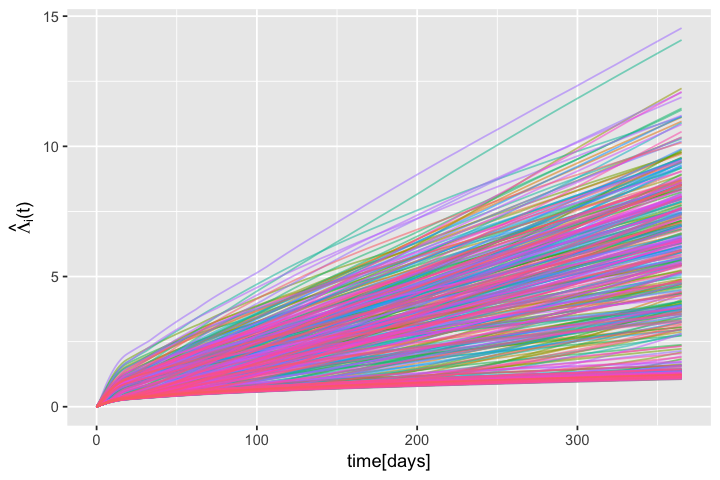

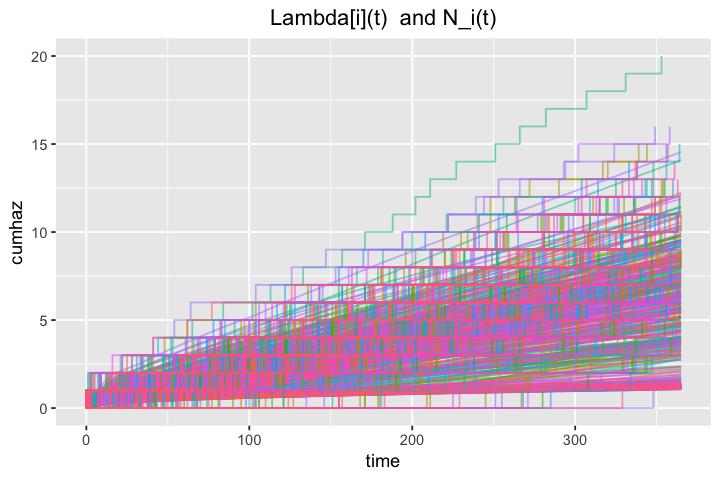

In [13]:
# select a sample to plot
sample_patients = sample(unique(sel_df$id),500)
sample = cumulative_hazard[cumulative_hazard$id %in% sample_patients,]
sample_N = sel_df[id %in% sample_patients,]
bh['id'] = 0

# plot
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    xlab('time[days]') + 
    ylab(TeX("$\\hat{\\Lambda}_i(t)")) + 
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))


# plot also realization
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_step(data = sample_N, aes(x= start, y=Nm,group = factor(id), color=factor(id))) +
    ggtitle(paste(expression(Lambda[i](t)),' and N_i(t)')) +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

In [15]:
# save
save(cumulative_hazard, file = '../../data/cumulative_hazards_beta.RData')

In [12]:
load('../../data/cumulative_hazards_beta.RData')

# Check Martingale residuals

In [17]:
# compute dataset of daily realizations (only once)
#source('compute_daily_realizations.R')
#daily_realizations_beta = compute_daily_realizations(sel_df)
#save(daily_realizations_beta, file = '../../data/daily_realizations_beta.RData')

In [14]:
# load dataset of daily realizations 
load('../../data/daily_realizations_beta.RData')
daily_realizations = daily_realizations_beta

In [15]:
# compute residuals
residuals = cbind(cumulative_hazard, Nt = daily_realizations$Nt)
residuals['residuals'] = residuals$cumhaz - residuals$Nt
residuals = data.table(residuals)

# compute mean residuals
mean_residuals = residuals[,list('residuals' = mean(residuals)), by = 'time']

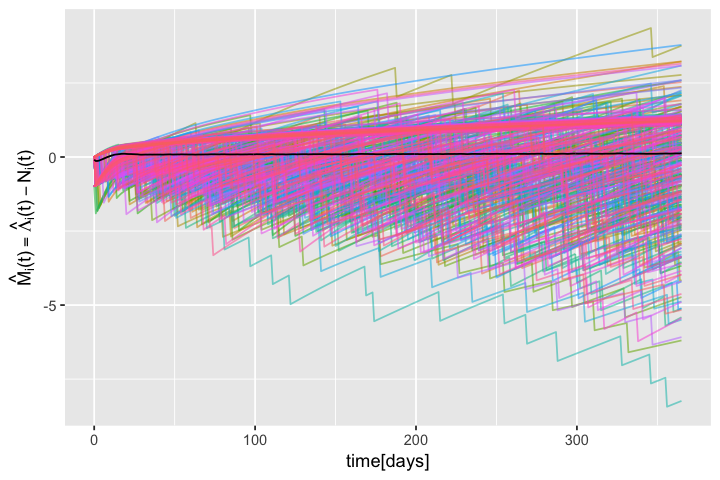

In [16]:
# select sample of patients to plot
sample_patients = sample(unique(sel_df$id),500)
sample = residuals[id %in% sample_patients,]

# plot
ggplot(data = mean_residuals, aes(x= time, y=residuals)) +
    geom_line() +
    geom_line(data = sample, aes(x= time, y=residuals, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line(data = mean_residuals, aes(x= time, y=residuals)) +
    xlab('time[days]') + 
    ylab(TeX("$\\hat{\\M}_i(t) = \\hat{\\Lambda}_i(t) - N_i(t)")) + 
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

The average of the residuals is approximately 0